In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install -U bayesian-optimization

In [6]:
# 데이터프레임 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  # 생략없이 모든 행, 열 출력

In [29]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기
warnings.filterwarnings('ignore')

In [51]:
# 구글드라이브 마운트 경로 설정
drive_path = '/content/drive/MyDrive/data/'
# 환율 CSV 파일 로드
result = pd.read_table(drive_path + 'exchange_rate_index.csv', sep=",", thousands=',', encoding='CP949')
data = pd.read_table(drive_path + 'exchange_rate_index.csv', sep=",", thousands=',', encoding='CP949')
# '날짜' 컬럼을 문자열에서 날짜 형식으로 변환
result['날짜'] = pd.to_datetime(result['날짜'])
data['날짜'] = pd.to_datetime(data['날짜'])
future_date = data[data['날짜'] >= '2023-09-01']
# 결측치 제거
data.dropna(subset=['DAX', 'VN', 'S&P 500', 'KOSPI', 'FTSE', 'DOWJONES', 'NIKKEI', 'NASDAQ'], inplace=True)
# 캐나다만 선택해서 테스트
# 서비스 국가 리스트
# country_list = ['아랍에미리트','아르헨티나','호주','방글라데시','바레인','브라질',
#                 '캐나다','스위스','칠레','중국','체코 공화국','페로제도',
#                 '유럽연합','제르제','홍콩','헝가리','인도네시아','인도',
#                 '이란','요르단','일본','한국','쿠웨이트','스리랑카',
#                 '리비아','멕시코','말레이시아','스발바르 얀마옌 제도','네팔','핏케언',
#                 '오만','필리핀','파키스탄','폴란드','카타르','루마니아',
#                 '러시아','사우디아라비아','스웨덴','싱가포르','태국','터키',
#                 '타이완','미국','우즈베키스탄','베트남','레소토']
country_list = ['미국','일본']

In [52]:
# 평균절대비율오차 MAPE 계산 함수
def MAPE(predict, test):
    cnt = 0
    idx = 0
    for i in range(len(predict)):
        if predict[i] == test[i] == 0:
            pass
        else:
            cnt += (abs(test[i] - predict[i]) / test[i]) * 100
            idx += 1
    return cnt / idx

# 랜덤포레스트 최적 하이퍼파라미터 탐색 범위 설정
params = {
    'n_estimators': (300, 400), #랜덤포레스트 안의 결정 트리 갯수
    'max_depth': (12, 14), #트리의 최대 깊이
    'min_samples_leaf': (2, 14), #리프노드가 되기 위한 최소한의 샘플 데이터 수
    'min_samples_split': (2, 14) #노드를 분할하기 위한 최소한의 데이터 수
}
data.head()

,날짜,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ,아랍에미리트,호주,방글라데시,바레인,브라질,캐나다,스위스,중국,체코,덴마크,유럽연합,영국,홍콩,헝가리,인도네시아,인도,요르단,일본,한국,쿠웨이트,멕시코,말레이시아,노르웨이,네팔,뉴질랜드,필리핀,파키스탄,폴란드,카타르,러시아,사우디아라비아,스웨덴,싱가포르,태국,튀르키예,타이완,미국,베트남,남아공
3,2016-01-04,10283.44,574.41,2012.66,235.00,6093.43,17148.94,18450.98,4497.86,322.36,853.07,15.04,3146.26,296.91,851.19,1190.31,181.10,47.22,172.96,1290.44,1744.27,152.76,4.06,8.59,17.77,1660.67,992.62,1.0,3898.58,68.40,275.77,134.41,11.12,802.04,25.12,11.22,298.82,322.90,16.05,315.52,140.15,831.87,32.83,402.61,35.71,1184.0,0.06,75.98
4,2016-01-05,10310.10,569.94,2016.71,236.40,6137.24,17158.66,18374.00,4484.18,322.63,854.62,15.15,3143.07,294.19,850.44,1182.40,181.94,47.65,171.94,1283.12,1743.19,152.88,4.10,8.52,17.86,1677.37,993.00,1.0,3903.16,68.76,272.66,133.44,11.13,799.46,25.25,11.35,299.43,326.57,16.28,315.87,139.39,831.78,32.77,400.77,35.92,1185.0,0.06,76.45
5,2016-01-06,10214.02,574.57,1990.26,235.45,6073.38,16906.51,18191.32,4443.98,324.28,845.97,15.19,3158.98,295.50,848.96,1181.20,182.61,47.41,171.67,1280.92,1748.63,153.66,4.09,8.59,17.91,1677.35,1005.06,1.0,3918.41,68.71,274.27,133.76,11.16,790.23,25.41,11.36,297.40,327.08,16.24,317.39,138.65,831.88,32.96,398.75,35.92,1191.0,0.06,76.17
6,2016-01-07,9979.85,565.36,1943.09,232.50,5954.08,16514.10,17767.34,4305.72,326.71,844.56,15.29,3184.54,298.20,852.36,1194.51,183.03,47.85,174.02,1298.40,1755.48,154.79,4.12,8.60,17.99,1690.50,1016.95,1.0,3941.53,68.40,273.19,134.05,11.23,796.08,25.48,11.45,297.32,329.49,16.09,319.72,140.24,836.24,33.11,399.59,36.07,1200.0,0.06,75.63
7,2016-01-08,9849.34,560.05,1922.03,233.80,5912.44,16346.45,17697.96,4270.78,325.88,844.96,15.27,3173.21,295.87,851.53,1199.16,181.56,48.36,174.55,1301.98,1750.67,154.34,4.16,8.59,17.89,1686.28,1013.12,1.0,3936.21,67.16,272.48,134.69,11.19,796.96,25.43,11.42,300.82,328.72,16.00,318.89,140.73,835.81,33.01,398.74,35.99,1197.0,0.06,74.54


In [ ]:
  # # 하이퍼 파라미터 최적화
  # from bayes_opt import BayesianOptimization
  # # 하이퍼파라미터 최적화를 위한 목적 함수를 정의
  # def rf_bo(max_depth, n_estimators, min_samples_split, min_samples_leaf):
  #     # 랜덤 포레스트 모델의 하이퍼파라미터를 설정
  #     rf_params = {
  #         'max_depth': int(round(max_depth)),
  #         'n_estimators': int(round(n_estimators)),
  #         'min_samples_split': int(round(min_samples_split)),
  #         'min_samples_leaf': int(round(min_samples_leaf)),
  #     }
  #     # RandomForestRegressor 모델을 초기화
  #     rf = RandomForestRegressor(**rf_params)
  #     # 모델을 훈련 데이터로 학습
  #     rf.fit(X, y.values.ravel())
  #     # 모델의 성능을 평가하고 반환
  #     score = rf.score(X, y)
  #     return score

  # # BayesianOptimization 객체를 생성
  # BO_rf = BayesianOptimization(f=rf_bo, verbose=2, pbounds=params, random_state=7279)

  # # 초기 데이터 포인트 10개를 사용하여 하이퍼파라미터 최적화를 시작하고,
  # # 그 후 10번의 반복(iteration)을 통해 최적화를 진행
  # BO_rf.maximize(init_points=10, n_iter=10)
  # # from sklearn.metrics import r2_score

  # max_params = BO_rf.max['params']
  # max_params['max_depth'] = int(max_params['max_depth'])
  # max_params['n_estimators'] = int(max_params['n_estimators'])
  # max_params['min_samples_leaf'] = int(max_params['min_samples_leaf'])
  # max_params['min_samples_split'] = int(max_params['min_samples_split'])

*****아랍에미리트 *****


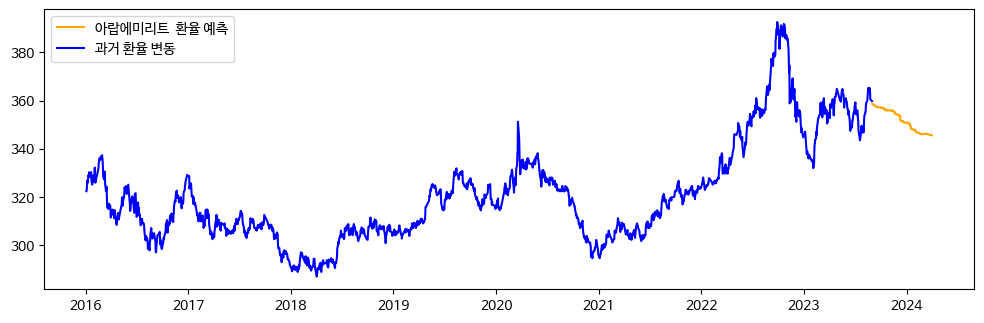

*****호주*****


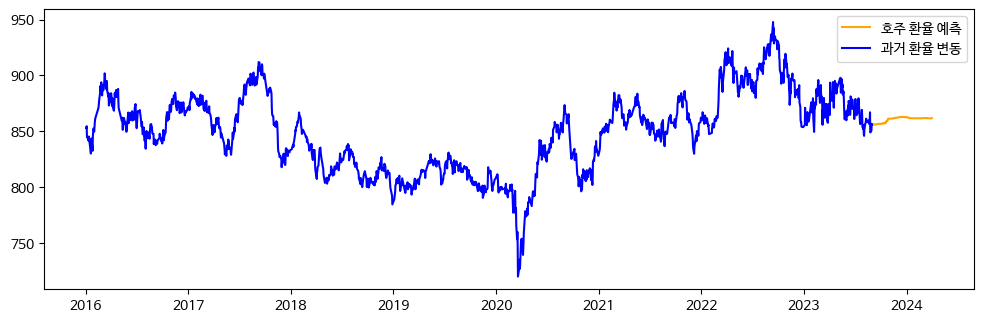

*****방글라데시*****


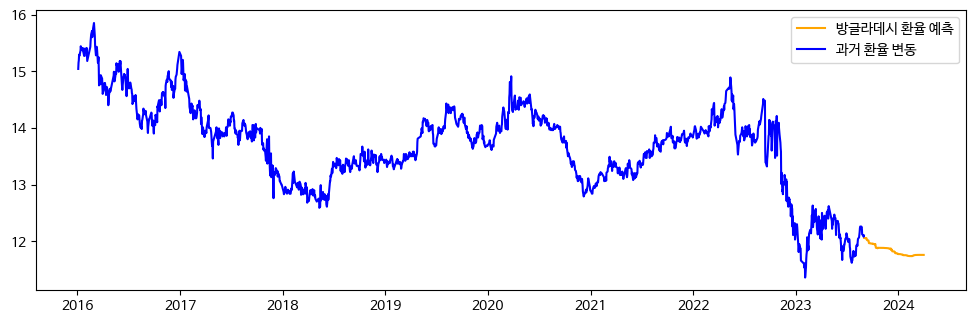

*****바레인*****


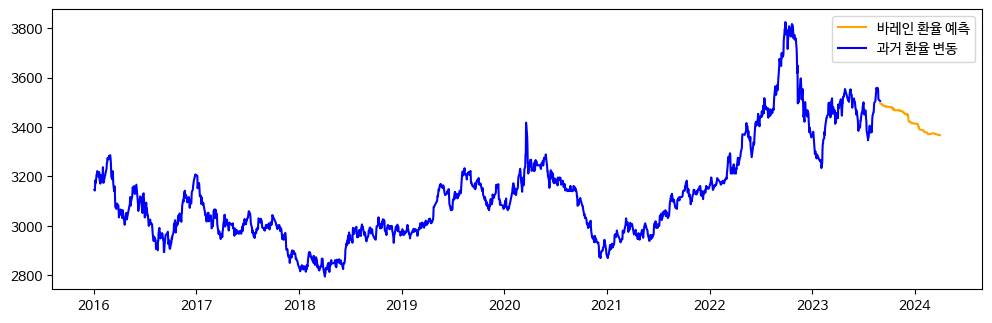

*****브라질*****


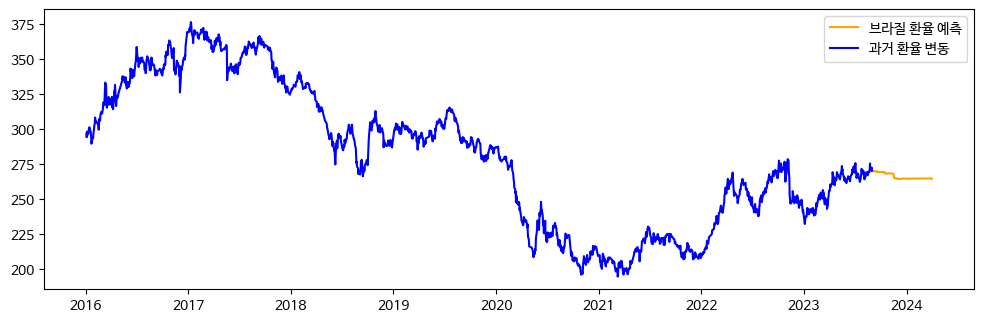

*****캐나다*****


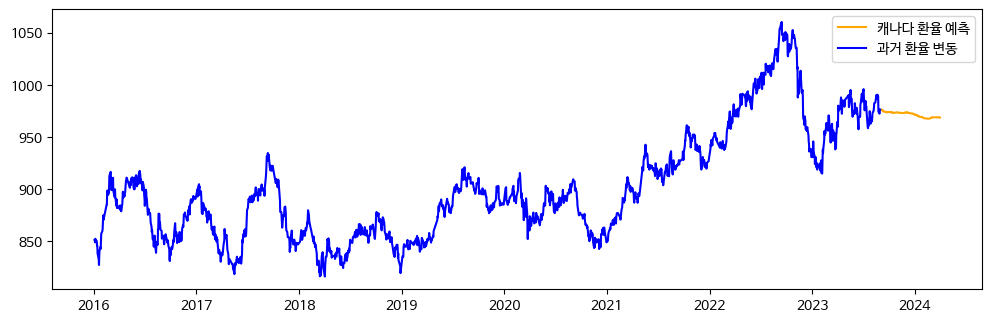

*****스위스*****


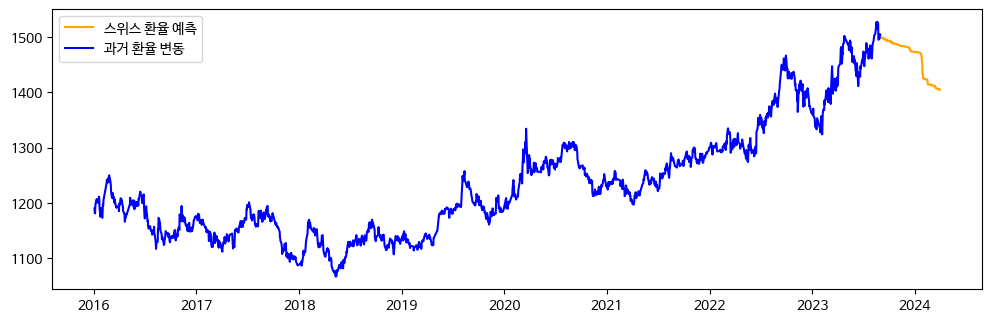

*****중국*****


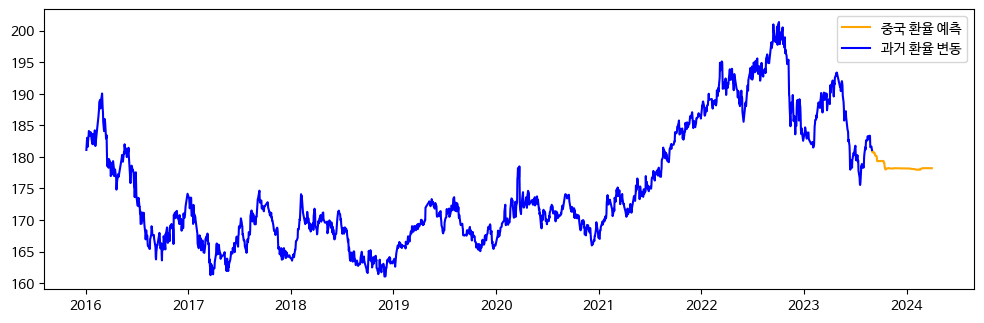

*****체코 *****


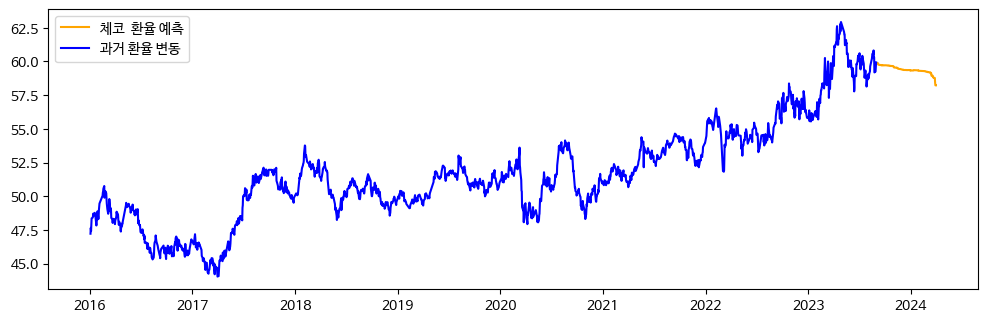

*****덴마크*****


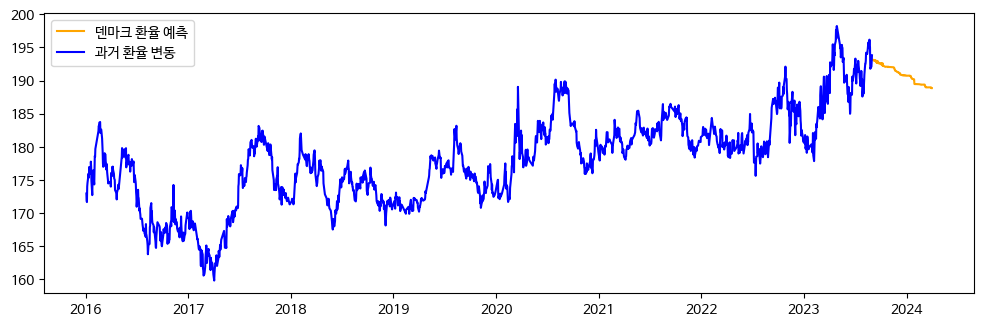

*****유럽연합*****


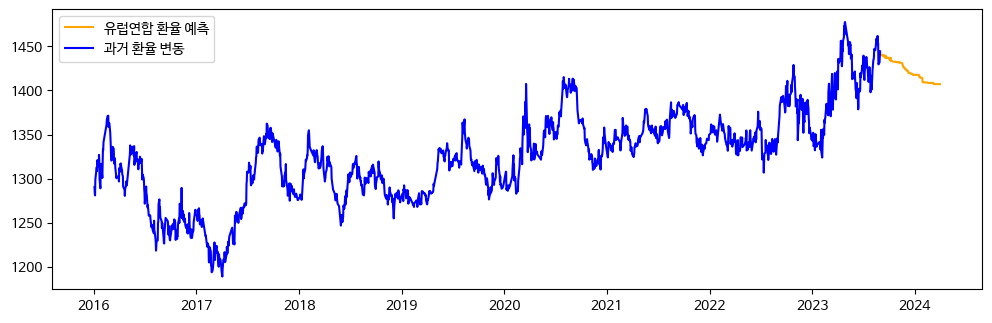

*****영국*****


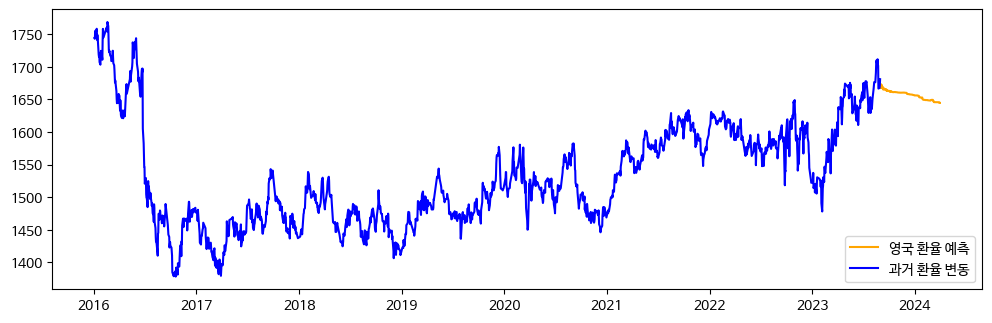

*****홍콩*****


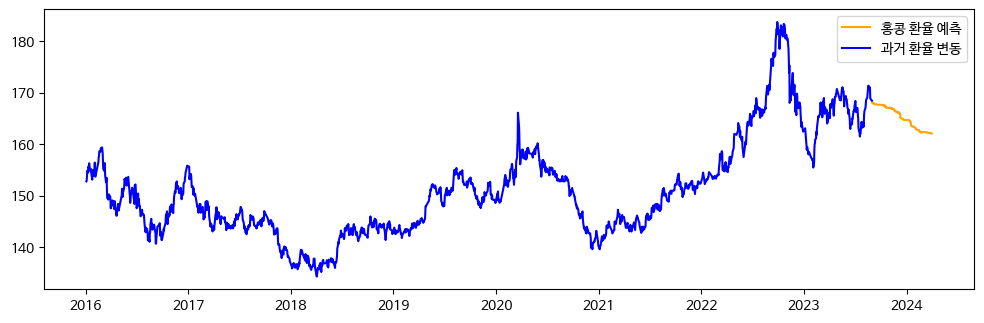

*****헝가리*****


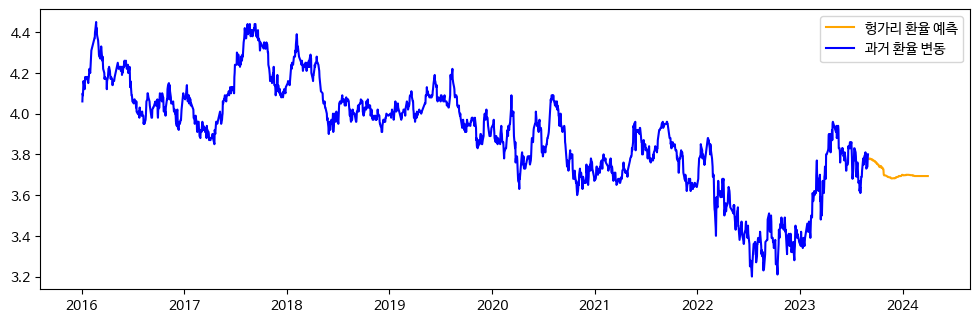

*****인도네시아*****


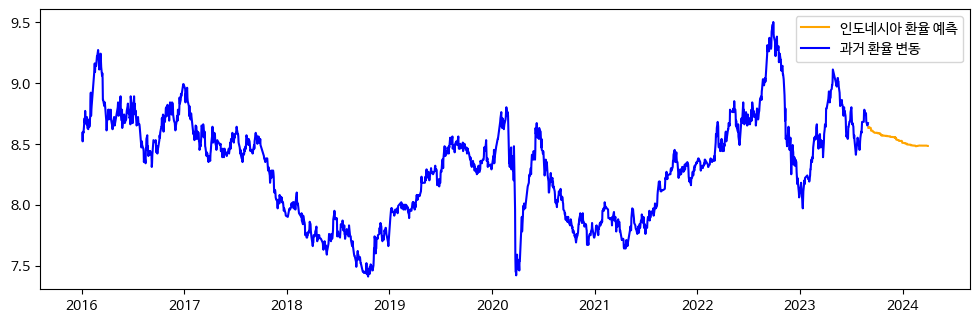

*****인도*****


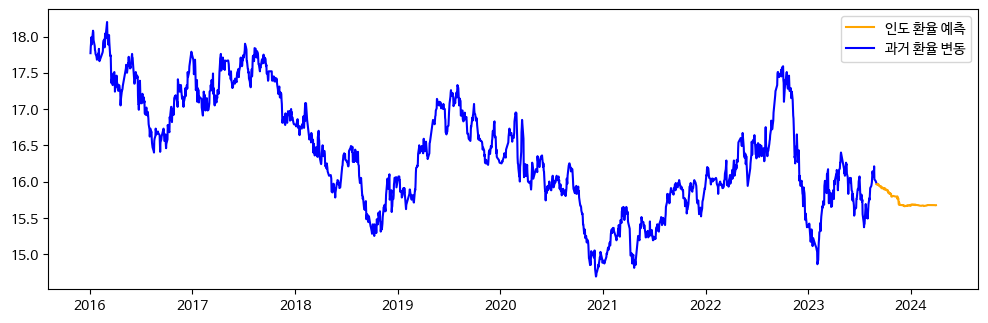

*****요르단*****


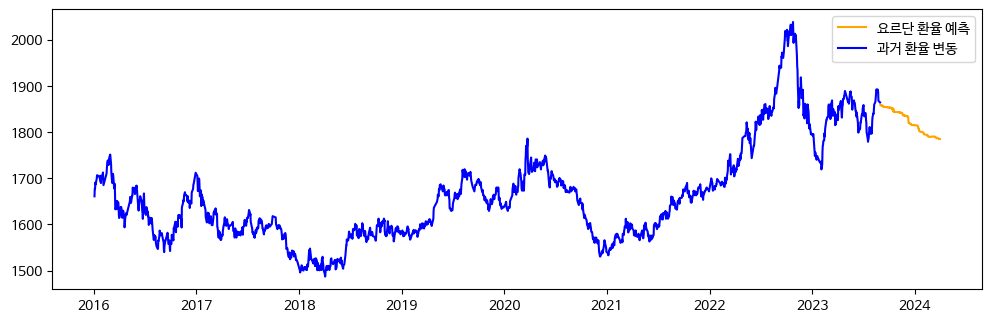

*****일본*****


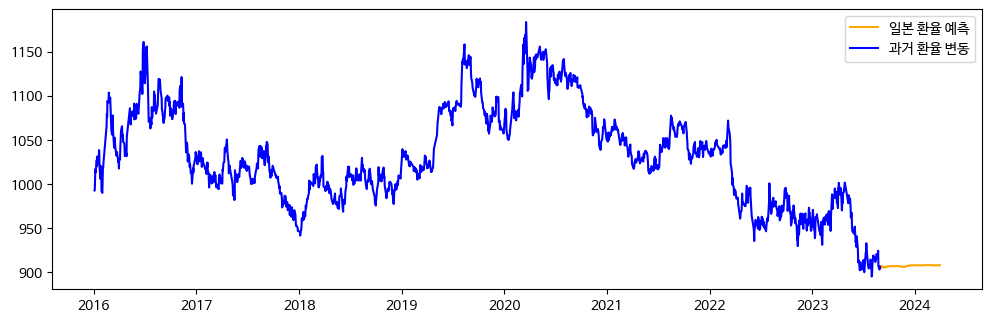

*****한국 *****


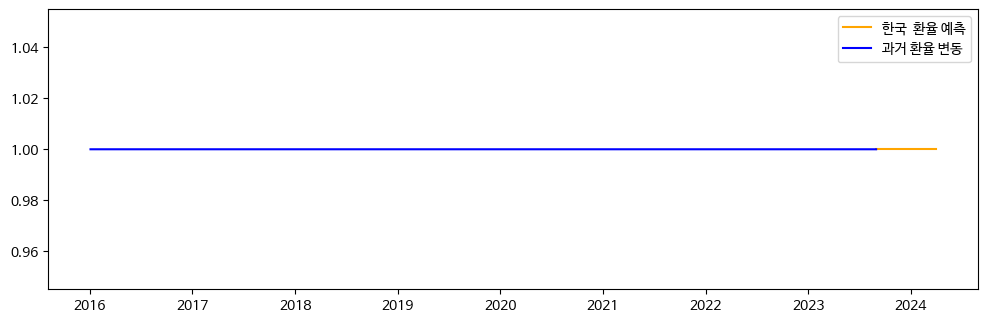

*****쿠웨이트*****


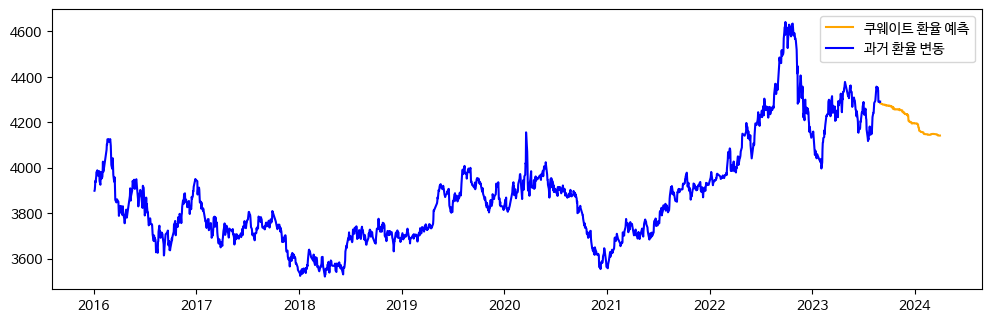

*****멕시코*****


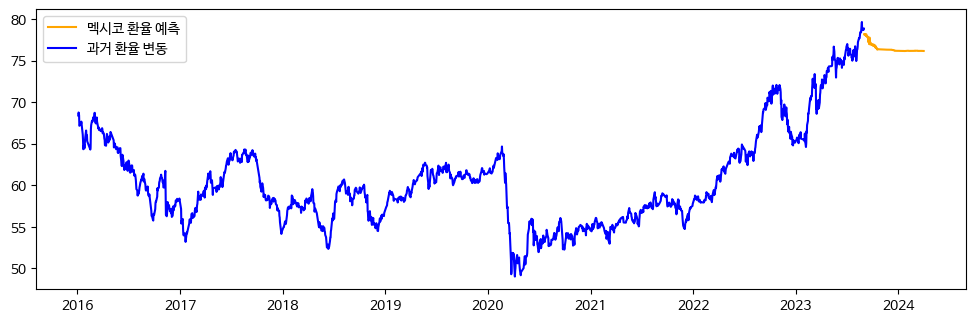

*****말레이시아*****


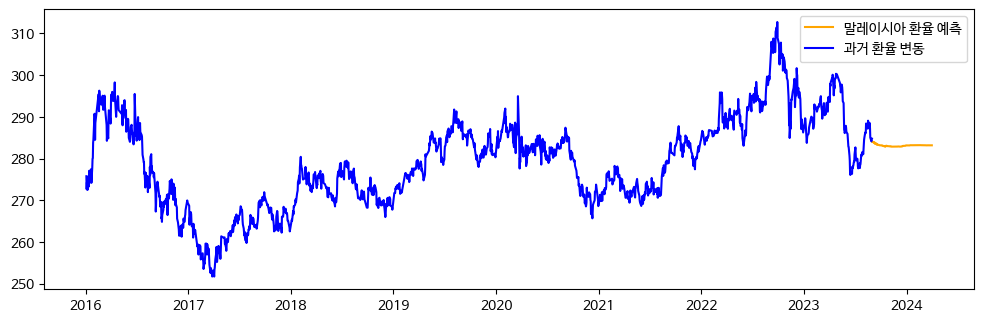

*****노르웨이*****


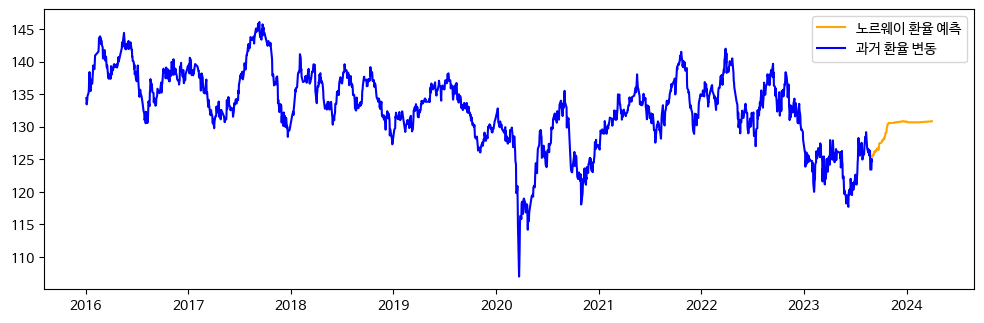

*****네팔*****


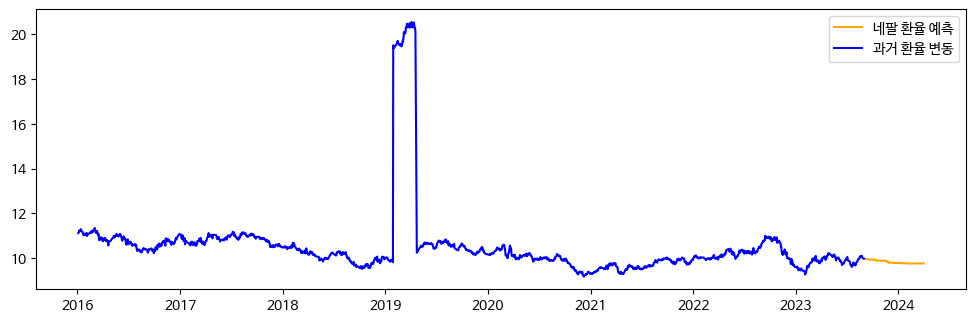

*****뉴질랜드*****


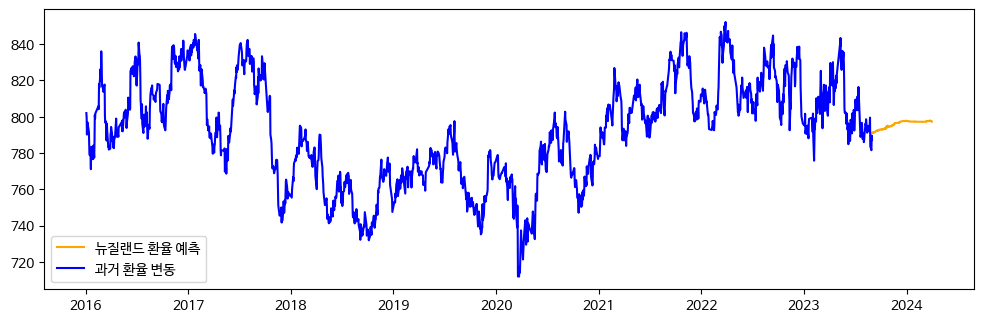

*****필리핀 *****


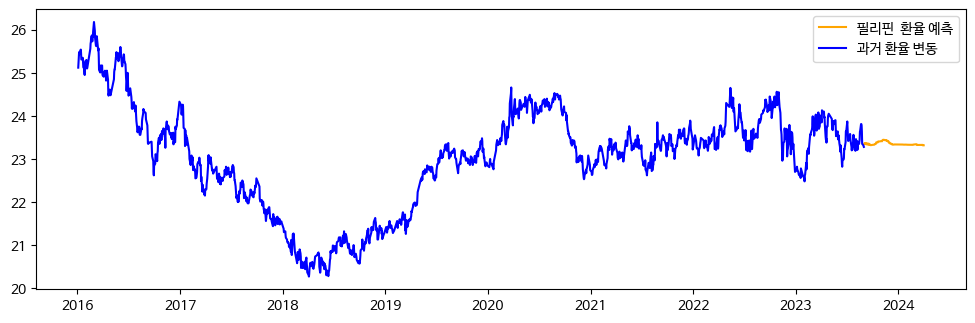

*****파키스탄*****


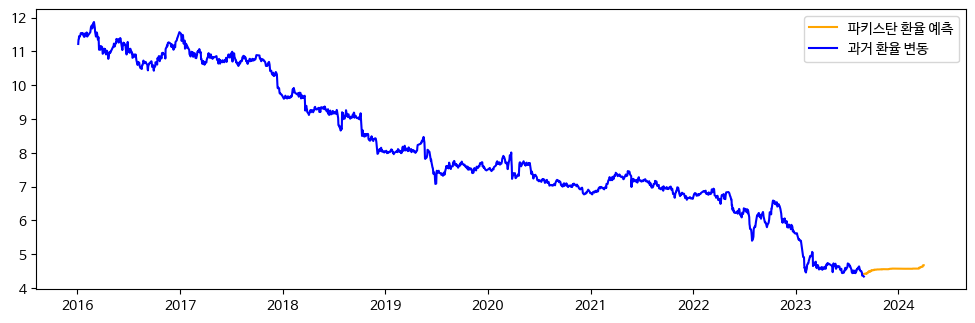

*****폴란드*****


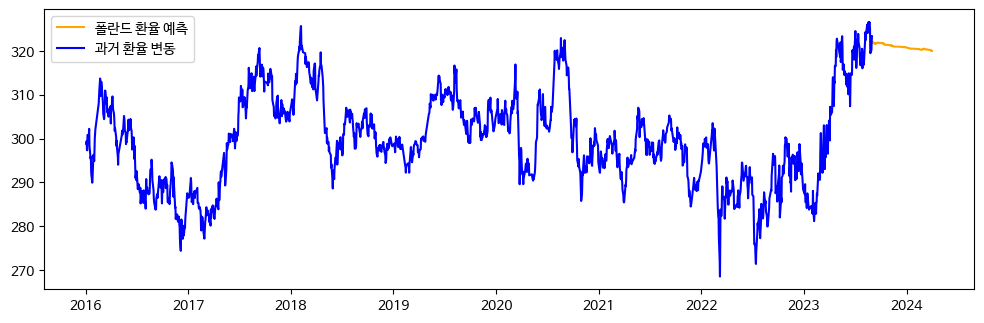

*****카타르*****


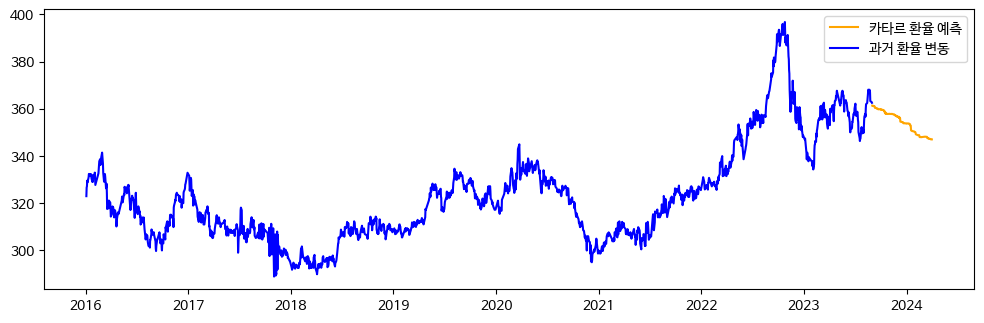

*****러시아 *****


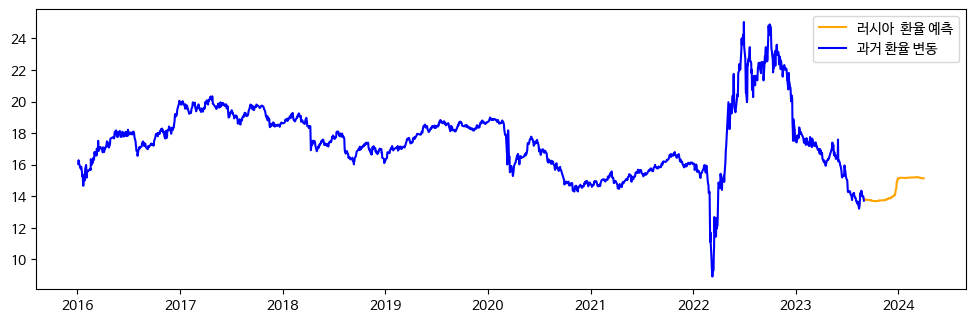

*****사우디아라비아*****


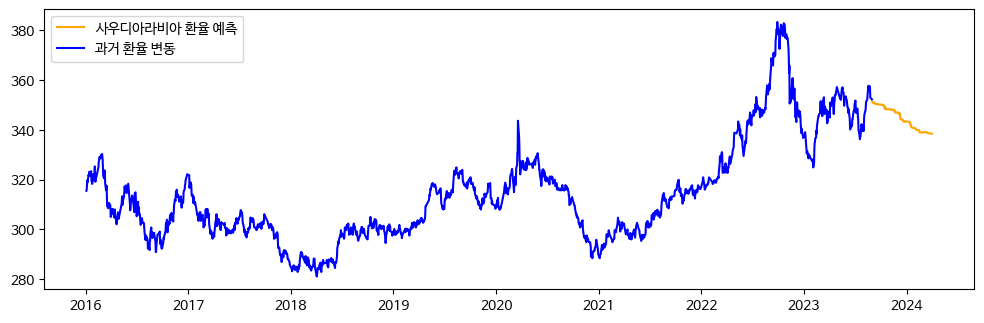

*****스웨덴*****


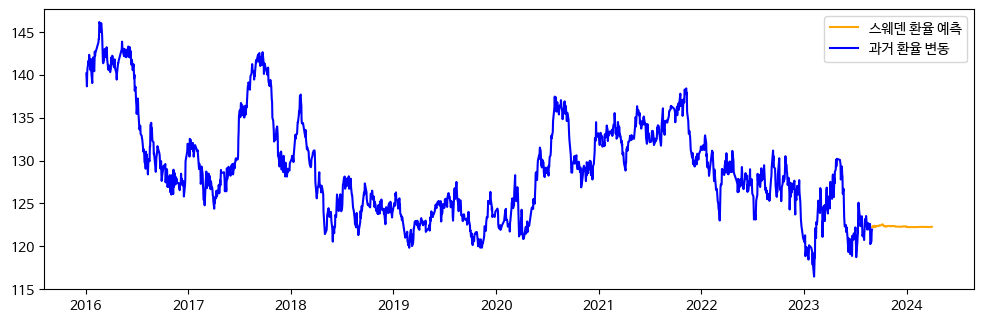

*****싱가포르*****


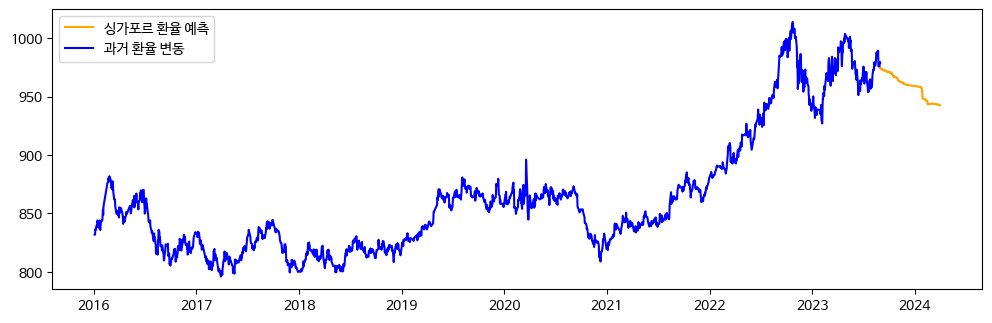

*****태국*****


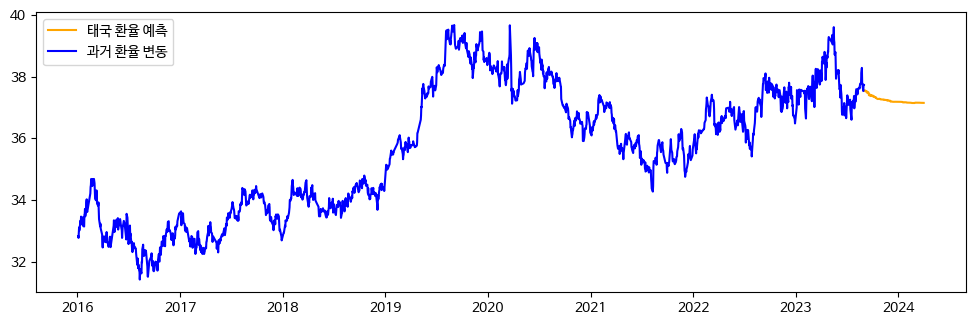

*****튀르키예*****


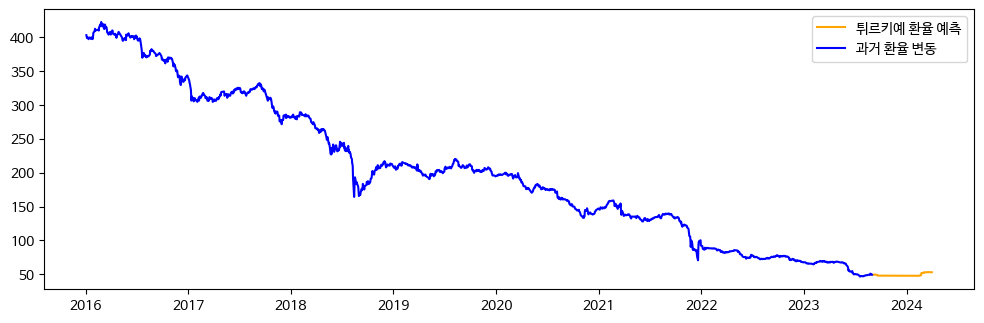

*****타이완*****


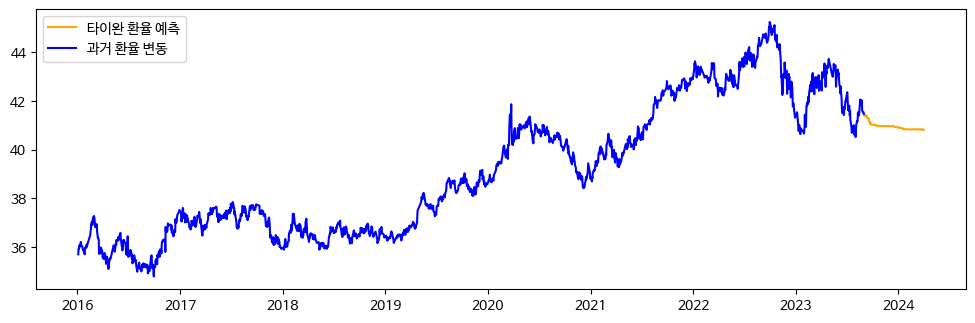

*****미국*****


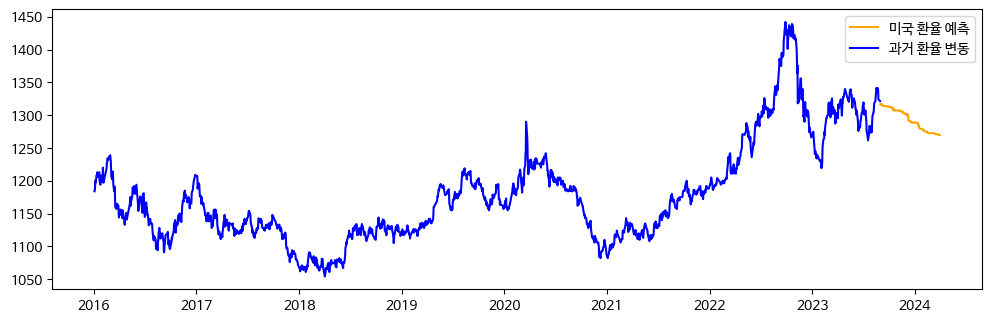

*****베트남*****


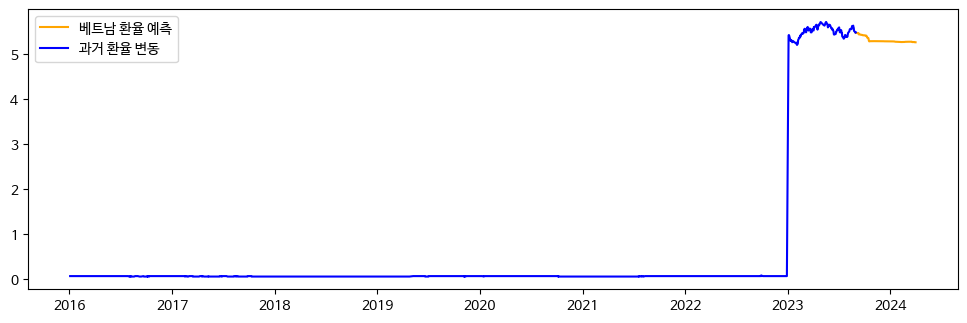

*****남아공*****


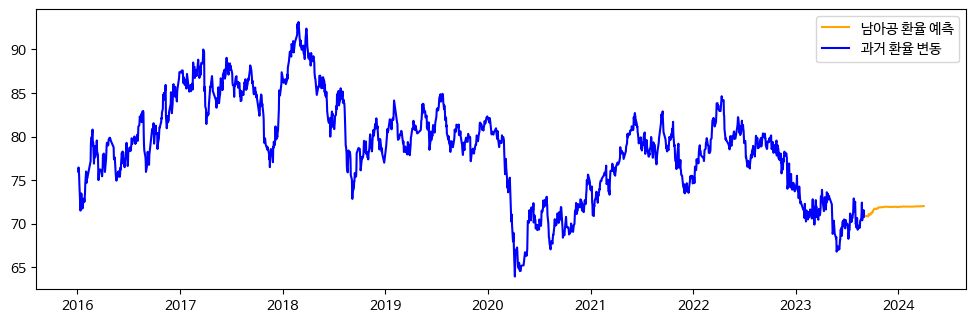

In [58]:
for contry_name  in data.columns[9:]:
  print('*****'+contry_name+'*****')
  train_data = data[data['날짜'] < '2023-09-01']
  test_data = data[data['날짜'] >= '2023-09-01']
  # 날짜 컬럼을 범주형 변수로 인코딩
  encoder = LabelEncoder()
  encoder.fit(train_data['날짜'])
  train_data["날짜"] = encoder.transform(train_data['날짜'])
  encoder = LabelEncoder()
  encoder.fit(test_data['날짜'])
  test_data["날짜"] = encoder.transform(test_data['날짜'])
  X = train_data[['DAX','VN','S&P 500','KOSPI','FTSE','DOWJONES','NIKKEI','NASDAQ' ]]
  y = train_data[[contry_name]]
  target = test_data[['DAX','VN','S&P 500','KOSPI','FTSE','DOWJONES','NIKKEI','NASDAQ' ]]
  max_params = {
      'n_estimators': 338, #랜덤포레스트 안의 결정 트리 갯수
      'max_depth': 14, #트리의 최대 깊이
      'min_samples_leaf': 2, #리프노드가 되기 위한 최소한의 샘플 데이터 수
      'min_samples_split': 2 #노드를 분할하기 위한 최소한의 데이터 수
  }
  BO_tuend_rf = RandomForestRegressor(**max_params)
  BO_tuend_rf.fit(X, y.values.ravel())
  BO_predict = BO_tuend_rf.predict(target)
  current_country = pd.DataFrame({
      '예측치' : BO_predict,
      '날짜' : future_date['날짜']
  })
  current_country['날짜'] = pd.to_datetime(current_country['날짜'])
  # '날짜'와 일치하는 행에 대해 '미국' 컬럼에 '예측치' 값을 복사
  for index, row in current_country.iterrows():
    date = row['날짜']
    if date in result['날짜'].values:
        prediction = row['예측치']
        result.loc[result['날짜'] == date, contry_name] = prediction

  current_country.set_index('날짜', inplace=True)
  real = data[['날짜',contry_name]]
  real['날짜'] = pd.to_datetime(real['날짜'])
  real.set_index('날짜', inplace=True)
  # 시각화
  plt.figure(figsize=(12,8))
  plt.subplot(212)
  plt.plot(current_country['예측치'],'orange', label=contry_name+' 환율 예측')
  plt.plot(real[contry_name],'blue', label='과거 환율 변동')
  plt.legend()
  plt.show()

In [56]:
result.tail()

,날짜,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ,아랍에미리트,호주,방글라데시,바레인,브라질,캐나다,스위스,중국,체코,덴마크,유럽연합,영국,홍콩,헝가리,인도네시아,인도,요르단,일본,한국,쿠웨이트,멕시코,말레이시아,노르웨이,네팔,뉴질랜드,필리핀,파키스탄,폴란드,카타르,러시아,사우디아라비아,스웨덴,싱가포르,태국,튀르키예,타이완,미국,베트남,남아공
3008,2024-03-27,16662.50266,1306.188391,4826.885614,347.312495,7526.922276,36977.39553,34413.27551,16732.55740,345.554199,860.894310,11.755545,3370.364289,264.103320,968.671053,1408.010577,178.226979,58.790314,188.926515,1408.237112,1643.635341,161.754769,3.700117,8.483891,15.695792,1787.474458,909.156274,1.0,4140.164725,76.218702,283.258229,131.316657,9.779277,797.212597,23.326365,4.660223,320.226220,346.903217,15.129093,338.271852,122.245029,944.619700,37.142405,55.698052,40.787315,1268.607063,5.277867,71.877019
3009,2024-03-28,16665.91581,1306.581397,4828.401397,347.384628,7527.555406,36988.16202,34421.89042,16738.35607,345.503534,860.882702,11.755969,3369.087383,263.976503,968.511798,1405.245698,178.226979,58.424984,188.905938,1408.209200,1643.474813,161.684004,3.699289,8.481823,15.695792,1786.242320,909.156274,1.0,4140.454775,76.218702,283.258229,131.325227,9.779009,796.880987,23.321658,4.675407,320.226220,346.751049,15.129093,338.134191,122.245029,944.283627,37.138112,55.606704,40.787315,1268.175040,5.277867,71.877019
3010,2024-03-29,16669.32897,1306.974404,4829.917179,347.436053,7528.326766,36998.92850,34430.50533,16744.14135,345.503534,860.849286,11.754640,3369.087383,263.966009,968.223561,1403.691366,178.225771,58.198715,188.858130,1407.193634,1642.943198,161.684004,3.699289,8.481313,15.695792,1786.242320,909.156274,1.0,4140.454775,76.218840,283.258229,131.325227,9.778166,796.757888,23.323172,4.698010,319.978699,346.751049,15.129093,338.127244,122.245029,944.283627,37.138112,55.581140,40.774839,1268.155366,5.277673,71.877019
3011,2024-03-30,16672.74213,1307.367411,4831.432962,347.493754,7528.294911,37009.69499,34439.12024,16749.93123,345.518148,860.849286,11.754640,3369.249395,263.966009,968.223561,1403.691366,178.225771,58.198715,188.858130,1407.193634,1642.943198,161.684004,3.699289,8.481313,15.697646,1786.406056,909.156274,1.0,4140.623641,76.218840,283.258229,131.325227,9.778166,796.757888,23.323172,4.698010,319.978699,346.751049,15.129093,338.127244,122.245029,944.283627,37.138112,55.581140,40.774839,1268.222920,5.277673,71.877019
3012,2024-03-31,16676.15529,1307.760417,4832.948744,347.564763,7528.621426,37020.46148,34447.73516,16755.73668,345.493399,860.849286,11.754640,3368.999921,263.966009,968.223561,1403.691366,178.225771,58.198715,188.858130,1407.193634,1642.943198,161.672513,3.699289,8.481313,15.697646,1786.291268,909.156274,1.0,4140.300711,76.218840,283.258229,131.324783,9.778166,796.757888,23.323172,4.698010,319.978699,346.735896,15.129093,338.071064,122.245029,944.283627,37.138112,55.581140,40.774839,1268.186431,5.277673,71.877019


In [57]:
# 구글 드라이브에 csv파일로 저장
import shutil
result.to_csv('exchange_rate_prediction.csv', index=False, encoding='utf-8-sig')
# Colab 파일을 Google 드라이브에 복사
shutil.copy('exchange_rate_prediction.csv', '/content/drive/MyDrive/data/')

'/content/drive/MyDrive/data/exchange_rate_prediction.csv'